#GIS-Part Ad Vacuum

Quellen:

1.   https://realpython.com/api-integration-in-python/
2.   https://openweathermap.org/current#geo
3.   https://docs.python-requests.org/de/latest/user/quickstart.html
4.   https://www.geeksforgeeks.org/read-json-file-using-python/

## Import Libraries

In [ ]:
#Get all preinstalled modules
%pip list

In [ ]:
import pandas as pd
pd.__version__

In [1]:
import requests
requests.__version__

'2.23.0'

In [5]:
import json
json.__version__

'2.0.9'

## API Call and Response

In [9]:
#Salzburg
input_coords = '{"type":"FeatureCollection","features":[{"type":"Feature","properties":{},"geometry":{"type":"Point","coordinates":[13.033218383789062,47.79355334155344]}}]}'
#Hallein
#testcoords = '{"type":"FeatureCollection","features":[{"type":"Feature","properties":{},"geometry":{"type":"Point","coordinates":[13.096046447753906,47.69104578658821]}}]}'
print(input_coords)

{"type":"FeatureCollection","features":[{"type":"Feature","properties":{},"geometry":{"type":"Point","coordinates":[13.033218383789062,47.79355334155344]}}]}


In [10]:
json_coords = json.loads(input_coords)
print(json.dumps(json_coords, indent=4, sort_keys=True))

{
    "features": [
        {
            "geometry": {
                "coordinates": [
                    13.033218383789062,
                    47.79355334155344
                ],
                "type": "Point"
            },
            "properties": {},
            "type": "Feature"
        }
    ],
    "type": "FeatureCollection"
}


In [ ]:
lat = json_coords["features"][0]["geometry"]["coordinates"][1]
print(lat)
lon = json_coords["features"][0]["geometry"]["coordinates"][0]
print(lon)

47.79355334155344
13.033218383789062


In [ ]:
#lat = '47.7994'
#lon = '13.044'
#resp = requests.get('http://api.openweathermap.org/data/2.5/weather?q=Salzburg&appid=')
resp = requests.get('http://api.openweathermap.org/data/2.5/weather?lat=' + str(lat) + '&lon=' + str(lon) + '&appid=')
if resp.status_code != 200:
    # This means something went wrong.
    raise ApiError('GET /tasks/ {}'.format(resp.status_code))

In [8]:
print(resp.text)

{"coord":{"lon":13.044,"lat":47.7994},"weather":[{"id":802,"main":"Clouds","description":"scattered clouds","icon":"03d"}],"base":"stations","main":{"temp":288.89,"feels_like":287.46,"temp_min":287.04,"temp_max":290.15,"pressure":1014,"humidity":36},"visibility":10000,"wind":{"speed":2.57,"deg":0},"clouds":{"all":40},"dt":1619021963,"sys":{"type":1,"id":6877,"country":"AT","sunrise":1618978036,"sunset":1619028322},"timezone":7200,"id":2766824,"name":"Salzburg","cod":200}


##Prettify JSON and get Wind Information

In [6]:
parsed = json.loads(resp.text)
print(json.dumps(parsed, indent=4, sort_keys=True))

{
    "base": "stations",
    "clouds": {
        "all": 40
    },
    "cod": 200,
    "coord": {
        "lat": 47.7994,
        "lon": 13.044
    },
    "dt": 1619021436,
    "id": 2766824,
    "main": {
        "feels_like": 287.57,
        "humidity": 36,
        "pressure": 1014,
        "temp": 288.99,
        "temp_max": 290.15,
        "temp_min": 287.04
    },
    "name": "Salzburg",
    "sys": {
        "country": "AT",
        "id": 6877,
        "sunrise": 1618978036,
        "sunset": 1619028322,
        "type": 1
    },
    "timezone": 7200,
    "visibility": 10000,
    "weather": [
        {
            "description": "scattered clouds",
            "icon": "03d",
            "id": 802,
            "main": "Clouds"
        }
    ],
    "wind": {
        "deg": 0,
        "speed": 2.57
    }
}


In [74]:
wind = parsed["wind"]
wind_speed = parsed["wind"]["speed"]
wind_dir = parsed["wind"]["deg"]
print(wind_speed)
print(wind_dir)

2.57
0


##Create wind cones

https://gis.stackexchange.com/questions/326681/getting-geometries-of-hurricanes-cone-of-uncertainty-using-shapely
https://link.springer.com/article/10.1007/s13595-019-0829-8
https://www.dwd.de/DE/service/lexikon/Functions/glossar.html?lv2=102936&lv3=103182


In [75]:
#Recalculation of movement in km
#Wind speed is calculated from m/s to km/h via *3.6
#Fires move 1/10th the km/h of the wind speed (see paper above), thus /10
wind_speed_move = (float(wind_speed)*3.6)/10 
print(wind_speed_move)

0.9251999999999999


In [79]:
#Recalculation from geographic to arithmetic degrees
#+180 because the fire goes away from the wind, not into the same direction
dir_new = (-(wind_dir+180)+450)%360
print(dir_new)

270


In [80]:
#Calculate x and y
dx=wind_speed_move*np.cos(np.radians(dir_new))
print(dx)
dy=wind_speed_move*np.sin(np.radians(dir_new))
print(dy)

-1.6995648278566965e-16
-0.9251999999999999


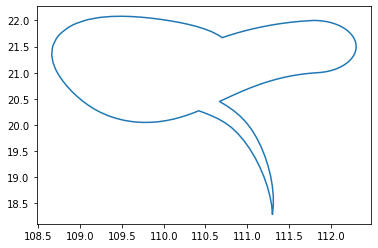

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import MultiPolygon, Polygon
from shapely.ops import cascaded_union
from scipy.interpolate import interp1d

# x, y: coords of forecast position
y = [18.3, 19.2, 20.0, 20.4, 20.7, 21.3, 21.6, 21.5, 20.8, 20.8, 21.5]
x = [111.3, 111.2, 110.9, 110.5, 110.2, 110.5, 110.0, 109.2, 109.4, 110.3, 111.8]
# r: radius of uncertainty
r = [0, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.5, 0.5, 0.5]
hours = [0, 6, 12, 18, 24, 36, 48, 60, 72, 96, 120]
# interpolate
points_num = 100
interp_hours = np.linspace(min(hours), max(hours), points_num)
x = interp1d(hours, x, kind='cubic')(interp_hours)
y = interp1d(hours, y, kind='cubic')(interp_hours)
r = interp1d(hours, r, kind='linear')(interp_hours)
# make polygon
thetas = np.linspace(0, 2 * np.pi, 360)
polygon_x = x[:,None] + r[:,None] * np.sin(thetas)
polygon_y = y[:,None] + r[:,None] * np.cos(thetas)

# circles
ps = [Polygon(i) for i in np.dstack((polygon_x, polygon_y))]

# list of convex hulls of subsequent circles
n = range(len(ps)-1)
convex_hulls = [MultiPolygon([ps[i], ps[i+1]]).convex_hull for i in n]

# Final polygon
polygons = cascaded_union(convex_hulls)

x,y=polygons.exterior.xy
plt.plot(x,y)